# Proof-of-concept: Classification of review deception via a neural network

We now wish to move on to a deep-learning approach to fake review opinion spam detection, shown in numerous papers and studies to be an effective method of classification. 
In this notebook, in a similar fashion to the other notebooks in this directory, we will use the small dataset with minimal features and set up a very basic neural network using Tensorflow and Keras.
Let's start by importing the modules we need.

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing import text
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


Now, let's start by getting our data. We use the get_data_frame function from the training helpers file, and split it into our X and Y (data and labels). 

It's been shown that a 70/30 train/test split is generally quite good, with a 70/30 train/validation split on the training data.

Training data is used to adjust weights, validation is used to make sure that these weight changes result in an increase in accuracy. Test data is used to run the final set of weights over data it's never seen before for final validation and to produce an accuracy.

In [2]:
from scripts import training_helpers as th
df = th.get_data_frame()

X = df['review']
y = df['deceptive']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

Now let's take a look at the vocab size of our data. 

In [3]:
def find_vocab_size(reviews):
  words = set()
  for review in reviews:
    for word in review.split():
      words.add(word)
  return len(words)

print(find_vocab_size(X))

19309


This is a tonne of features, so let's use the keras Tokenizer, which lets us choose a number of the most commonly occuring words in our vocab. We'll set this number to 2000, to get rid of the least important ones, and then fit it on our data.

In [4]:
NUM_WORDS = 2000
tokenizer = text.Tokenizer(num_words=NUM_WORDS)
tokenizer.fit_on_texts(X)

Now let's define a function that takes a list of reviews and converts it to a list of tfidf vectors based on the above dictionary.

In [5]:
def tokenize(data):
    return tokenizer.texts_to_matrix(data, mode='tfidf')

train_data = tokenize(X_train)
test_data = tokenize(X_test)

Lets take a look at these tfidf vectors and the shape of them.

In [6]:
print(train_data[0])

[0.         2.05026979 2.07090887 ... 0.         0.         0.        ]


Looks good. Now that our data is prepared, lets create our neural network.

Let's create a basic network with one hidden layer of 4 nodes, fully connected (Dense). 

The first layer needs to specify the size of the input in 'input_shape', which is the number of features in an input. Its output size will be the first parameter (4). In this case, we use a very small number of nodes as it's a very small dataset, so 4 is optimal to prevent overfitting.

The following layers can infer the size.

We use the Adam optimizer, which is a replacement optimizer for stochastic gradient descent, and the binary_crossentropy loss function, which is the binary log loss function.

In [7]:
model = keras.Sequential([
    keras.layers.Dense(4, activation=tf.nn.relu, input_shape=(NUM_WORDS,)),
    keras.layers.Dense(4, activation=tf.nn.relu),
    keras.layers.Dense(1, activation=tf.nn.sigmoid)
])
 
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 4)                 8004      
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 20        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 5         
Total params: 8,029
Trainable params: 8,029
Non-trainable params: 0
_________________________________________________________________


Now let's train and validate the model. We fit it on the training data, using 70% for training (weight adjustment) and 30% for validation. Validation is important as it's data that hasn't been seen in the training, so we get a feel for how well the model generalizes and make sure overfitting does not occur. In general, how good a model is can be judged based on how low it's validation loss is.

Batch size is how many chunks we want to split out data up into. We cant pass the entire dataset in one epoch, so we split it up into chunks of size n, where n is the batch size. The number of iterations it takes to complete one epoch is the training size / batch size.

In [8]:
history = model.fit(train_data,
                      y_train,
                      epochs=12,
                      batch_size=16,
                      validation_split=0.3,
                      verbose=2)

Train on 784 samples, validate on 336 samples
Epoch 1/12
 - 1s - loss: 0.6846 - acc: 0.5268 - val_loss: 0.6591 - val_acc: 0.5625
Epoch 2/12
 - 0s - loss: 0.5546 - acc: 0.7372 - val_loss: 0.4783 - val_acc: 0.8065
Epoch 3/12
 - 0s - loss: 0.3165 - acc: 0.9082 - val_loss: 0.3518 - val_acc: 0.8631
Epoch 4/12
 - 0s - loss: 0.1632 - acc: 0.9719 - val_loss: 0.2964 - val_acc: 0.8810
Epoch 5/12
 - 0s - loss: 0.0939 - acc: 0.9860 - val_loss: 0.2663 - val_acc: 0.9018
Epoch 6/12
 - 0s - loss: 0.0581 - acc: 0.9949 - val_loss: 0.2663 - val_acc: 0.8988
Epoch 7/12
 - 0s - loss: 0.0365 - acc: 1.0000 - val_loss: 0.2665 - val_acc: 0.8958
Epoch 8/12
 - 0s - loss: 0.0253 - acc: 1.0000 - val_loss: 0.2664 - val_acc: 0.8958
Epoch 9/12
 - 0s - loss: 0.0184 - acc: 1.0000 - val_loss: 0.2741 - val_acc: 0.8988
Epoch 10/12
 - 0s - loss: 0.0139 - acc: 1.0000 - val_loss: 0.2755 - val_acc: 0.8929
Epoch 11/12
 - 0s - loss: 0.0109 - acc: 1.0000 - val_loss: 0.2837 - val_acc: 0.8958
Epoch 12/12
 - 0s - loss: 0.0087 - acc:

We can see above that the validation loss consistently decreases as the epochs go on, and validation accuracy consistently increases. If the validation loss is decreasing up until the end, then increase the number of epochs or reduce the batch size.

From the val_acc seen at the end of every epoch, we can predict the value of accuracy on the test data. Lets evaluate the model and give it a try.

In [9]:
results = model.evaluate(test_data, y_test)
print(model.metrics_names, results)

480/480 [==============================] - 0s 88us/step
['loss', 'acc'] [0.4896490034957727, 0.8166666666666667]


Yup, the accuracy is about as predicted! And we have a pretty low loss too. This indicates a good model that will generalize well.
Let's plot the training and validation losses.

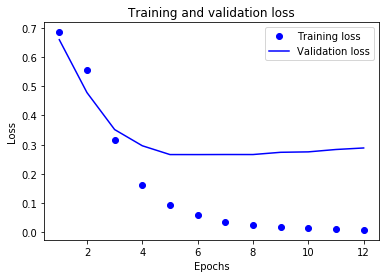

In [10]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

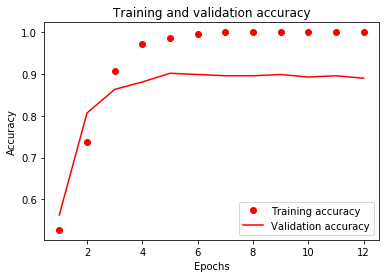

In [11]:
# "bo" is for "blue dot"
plt.plot(epochs, acc, 'ro', label='Training accuracy')
# b is for "solid blue line"
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Convolutional Model

In this POC, we will still use BOW features, and look further into the use of word embeddings with a CNN in a seperate future experiment.

One paper [Semi-supervised Convolutional Neural Networks for text categorization via region embedding](https://papers.nips.cc/paper/5849-semi-supervised-convolutional-neural-networks-for-text-categorization-via-region-embedding.pdf) builds a semi supervised convolutional network using bow by using unsupervised learning to produce two-view embeddings of the words. This however is a lot of work for a proof of concept, so we will not try to perform the same work.

However this model is not expected to be very predictive on bag of words because the word order is not preserved. Word order is important for Convolutional Networks, using embeddings this would be preserved because each row would represent the next word in the sentence. By treating the bag of words as two dimensional input, with row number of one, we can drop in our embeddings with the same process as before, but with a greater number of rows.

In [12]:
train_data.shape

(1120, 2000)

In our input data we have 1120 samples and a vocabulary of size 2000, which will be our number of columns. Each input or 'image' in the context of Convolutional networks will be an image with 1 row, 2000 columns and depth 1. We will have 1120 of these input images. 

In [13]:
batches = 1120
convolutional_data = np.array(np.split(np.array([[[y] for y in z] for z in train_data]), batches))
convolutional_data.shape

(1120, 1, 2000, 1)

Based on findings in a paper [A Sensitivity Analysis of (and Practitioners’ Guide to) Convolutional Neural Networks for Sentence Classification](https://arxiv.org/pdf/1510.03820.pdf) we will make a number of decisions:

* We will use the ReLU implementation as our activation function.
* While working with only sliding one direction over the data, we will use a filter size of 10
* We will try 50 filters for our POC
* Our vocab size is magnitudes of order larger than our filter size. We'll pool the result of each convolution to 1 value.
* We can start with 1 convolutional layer, like other research has, [Convolutional neural networks for sentence classification](https://www.aclweb.org/anthology/D14-1181)
* We'll include a dropout layer to mitigate overfitting.

In [14]:
from keras import layers
from keras.activations import relu

model = keras.Sequential([
    keras.layers.Conv2D(
        filters=50,
        kernel_size=(1, 10),
        data_format="channels_last",
        input_shape=(1, 2000, 1),
        activation=relu),
    keras.layers.MaxPooling2D(pool_size=(1, 10)),
    keras.layers.Dropout(0.2),
    keras.layers.Flatten(),
    keras.layers.Dense(2, activation='softmax')
])

In [15]:
model.compile(
    loss=keras.losses.categorical_crossentropy,
    optimizer='adam',
    metrics=['accuracy'])

We will convert our targets to represent two classes, with arrays of length 2, where element 0 will be 1 for class 0, and element 1 will be 1 for class 1:

In [16]:
convolutional_targets = keras.utils.to_categorical(y_train)
convolutional_targets.shape

(1120, 2)

In [17]:
num_epochs = 12
conv_history = model.fit(
    convolutional_data,
    convolutional_targets,
    validation_split=0.2,
    epochs=num_epochs,
    verbose=1).history

Train on 896 samples, validate on 224 samples
Epoch 1/12
896/896 [==============================] - 2s 3ms/step - loss: 0.6727 - acc: 0.5681 - val_loss: 0.5510 - val_acc: 0.7054
Epoch 2/12
896/896 [==============================] - 2s 2ms/step - loss: 0.5225 - acc: 0.7288 - val_loss: 0.5210 - val_acc: 0.6964
Epoch 3/12
896/896 [==============================] - 2s 2ms/step - loss: 0.4653 - acc: 0.7801 - val_loss: 0.4960 - val_acc: 0.7321
Epoch 4/12
896/896 [==============================] - 2s 2ms/step - loss: 0.4265 - acc: 0.8036 - val_loss: 0.5139 - val_acc: 0.7500
Epoch 5/12
896/896 [==============================] - 2s 2ms/step - loss: 0.3818 - acc: 0.8359 - val_loss: 0.4769 - val_acc: 0.7545
Epoch 6/12
896/896 [==============================] - 2s 2ms/step - loss: 0.3458 - acc: 0.8415 - val_loss: 0.4860 - val_acc: 0.7634
Epoch 7/12
896/896 [==============================] - 2s 2ms/step - loss: 0.3365 - acc: 0.8538 - val_loss: 0.5004 - val_acc: 0.7455
Epoch 8/12
896/896 [==========

In [18]:
epochs = range(1, num_epochs+1)

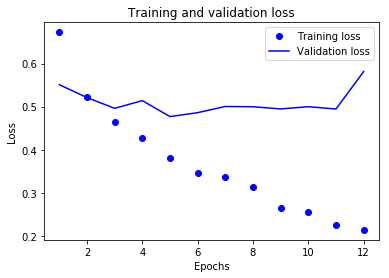

In [19]:
plt.plot(epochs, conv_history['loss'], 'bo', label='Training loss')
plt.plot(epochs, conv_history['val_loss'], 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

We can see that the both the training loss and validation loss start by decreasing, until the validation loss begins to rise again. This shows that after a short number of epochs we start to see overfitting, where the model is fit to well to our data. Adding dropout layers helps reduce this effect, but we are using such a small dataset that it is likely too easy to reproduce what the model is training on.

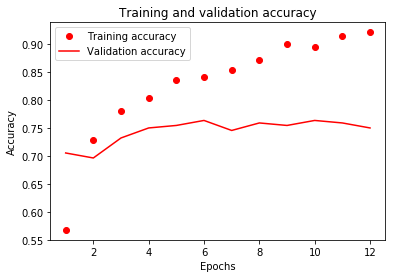

In [20]:
plt.plot(epochs, conv_history['acc'], 'ro', label='Training accuracy')
plt.plot(epochs, conv_history['val_acc'], 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

Our training accuracy increases consistently, as the model fits more and more closely to the training set. The validation increases but quickly levels out, as the model is not becoming more predictive on unseen data.

We should also note that with such a small dataset our results are highly variable.

# Recurrent Model(s)

We now wish to move on to recurrent neural networks. In this POC we will use our OpSpam word embeddings, as RNN networks rely heavily on the temporal nature of sentences and our Word2Vec model is a far better representation of this than a simple BOW model.

